<a href="https://colab.research.google.com/github/cmunozcortes/classification_textual_data/blob/master/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Question 1: Getting Familiar With the Dataset

Plot a histogram of the number of training documents for each of the 20 categories to check if they are evenly distributed.

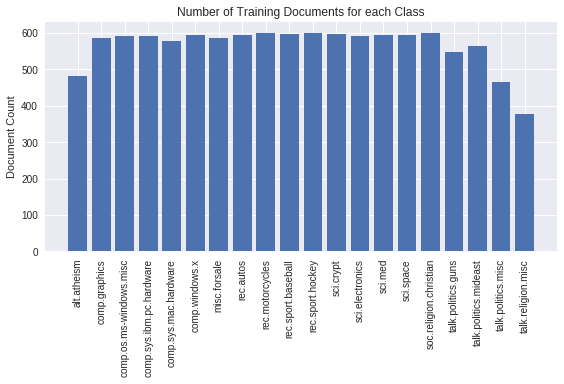

In [1]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import matplotlib.pyplot as plt

ng_train = fetch_20newsgroups(subset='train')
targets, counts = np.unique(ng_train.target, return_counts=True)
plt.bar(targets, counts, tick_label=ng_train.target_names)
plt.xticks(rotation='vertical')
plt.title('Number of Training Documents for each Class')
plt.ylabel('Document Count')
plt.tight_layout()
plt.show()

## Question 2: Feature Extraction

Use the following specs to extract features from the textual data:
*   Use the “english” stopwords of the CountVectorizer
*   Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)
*   Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos_tag
*   Use min_df=3

Report the shape of the TF-IDF matrices of the train and test subsets respectively.

In [2]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)

categories = ['comp.graphics', 'comp.os.ms-windows.misc', 
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 
              'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 
              'rec.sport.hockey']
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories,
                                   shuffle = True, random_state = None)
test_dataset  = fetch_20newsgroups(subset = 'test', categories = categories,
                                   shuffle = True, random_state = None)

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from string import punctuation

stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_eng = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_eng), set(punctuation), 
                              set(stop_words_skt))

from nltk import pos_tag

wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag):
  """Convertes Penn Treebank tags to WordNet"""
  morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
  try:
    return morphy_tag[penntag[:2]]
  except:
    return 'n'

def lemmatize(list_word):
  return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
         for word, tag in pos_tag(list_word)]

def stem_remove_punc(text):
  return (word for word in lemmatize(analyzer(text))
         if word not in combined_stopwords and not word.isdigit())

analyzer = text.CountVectorizer().build_analyzer()
tfidf_trans = text.TfidfTransformer()

vectorizer = text.CountVectorizer(min_df=3, analyzer=stem_remove_punc,
                                  stop_words='english')
train_counts = vectorizer.fit_transform(train_dataset.data)
test_counts = vectorizer.transform(test_dataset.data)

X_train_tfidf = tfidf_trans.fit_transform(train_counts)
X_test_tfidf = tfidf_trans.transform(test_counts)

print('\nShape of TF-IDF matrices:')
print('Train data set: ', X_train_tfidf.shape)
print('Test data set: ', X_test_tfidf.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.

Shape of TF-IDF matrices:
Train data set:  (4732, 16292)
Test data set:  (3150, 16292)


## Question 3: Dimensionality Reduction

Reduce the dimensionality of the data using the methods above:
*   Apply LSI to the TF-IDF matrix corresponding to the 8 categories with k = 50; so each document is mapped to a 50-dimensional vector
*   Also reduce dimensionality through NMF (k = 50) and compare with LSI:
  * Which one is larger, the ...



### LSA/LSI

In [3]:
from sklearn.decomposition import TruncatedSVD

# Based on the source code for TruncatedSVD, the return value corresponds to
# X_transformed = U * sigma
# VT can be obtained by calling .components_ on svd
svd = TruncatedSVD(n_components=50)
X_transformed = svd.fit_transform(X_train_tfidf)
print(X_transformed.shape)

(4732, 50)


### NMF

In [5]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=50)
W_train_reduced_nmf = nmf.fit_transform(X_train_tfidf)
print(W_train_reduced_nmf.shape)

(4732, 50)


### Comparison between LSA/LSI and NMF

In [6]:
# Calculate || X - W*H ||^2 for NMF
H_train_reduced_nmf = nmf.components_
np.sum(np.array(X_train_tfidf - W_train_reduced_nmf.dot(H_train_reduced_nmf))**2)

4143.497036460808

In [10]:
# Calculate || X - U_k * Sigma_k * (V_k)^T ||^2 for LSA/LSI
VT = svd.components_
np.sum(np.array(X_train_tfidf - X_transformed.dot(VT))**2)

4107.9653576566225